# Time Series Analysis using pmd-AutoARIMA

In [2]:
#Time Series
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import explained_variance_score
#from matplotlib.mpl_finance import fetch_historical_yahoo, parse_yahoo_historical_ochl
rcParams['figure.figsize'] = 15,5

### Loading data
One way to load data using `yfinance`.

In [3]:
import yfinance as yf

#define the ticker symbol
tickerSymbol = 'MSFT'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2020-1-25')

#see your data
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-12-31,23.971933,23.979671,23.585039,23.585039,31929700,0.0,0
2010-01-04,23.693373,24.064791,23.670159,23.948723,38409100,0.0,0
2010-01-05,23.871340,24.064786,23.708844,23.956455,49749600,0.0,0
2010-01-06,23.894552,24.049310,23.615990,23.809437,58182400,0.0,0
2010-01-07,23.701109,23.755275,23.360644,23.561829,50559700,0.0,0
...,...,...,...,...,...,...,...
2020-01-17,164.588475,164.637633,162.632126,164.273895,34371700,0.0,0
2020-01-21,163.860969,165.345441,163.615198,163.684021,29517200,0.0,0
2020-01-22,164.568782,164.657272,162.877871,162.897537,24138800,0.0,0


### Load the time series 
We load the time series using another method and create a date threshold to help generate a test set. We also plot the data. The data is in OHLC format.

[*********************100%***********************]  1 of 1 completed


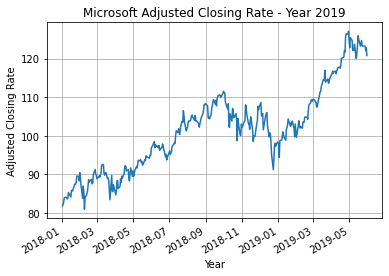

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,81.848274,22483800
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.229195,26061400
2018-01-04,86.589996,87.660004,86.570000,87.110001,82.952919,21912000
2018-01-05,87.660004,88.410004,87.430000,88.190002,83.981377,23407100
2018-01-08,88.199997,88.580002,87.599998,88.279999,84.067101,22113000
...,...,...,...,...,...,...
2019-05-24,126.910004,127.419998,125.970001,126.239998,123.273575,14123400
2019-05-28,126.980003,128.000000,126.050003,126.160004,123.195465,23128400
2019-05-29,125.379997,125.389999,124.040001,124.940002,122.004120,22763100


In [8]:
# Get the data for the indicated stock
data = yf.download('MSFT','2018-01-01','2019-12-31')

#Set a threshold for train-test-split of the series. Data before this is 
#training and after this is test data.

date_thresh = datetime.strptime('2019-06-01',"%Y-%m-%d").date()
data_train = data[:date_thresh]
data_test = data[date_thresh:]
# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the close price of the AAPL
data_train['Adj Close'].plot()
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Rate')
plt.title('Microsoft Adjusted Closing Rate - Year 2019')
plt.grid()
plt.show()
data_train

### Exploratory Data Analysis
Time series predictions are best done on a stationary series. The following are the attributes of a stationary series.

- Rolling mean is constant.
- Rolling standard deviation is constant.
- Autocorrelation is near zero.

Let us check stationarity of series using ADF(Augmented Dickey Fuller Test).

In [9]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data_train['Adj Close'])

(0.453063304246509, True)

The results indicate that the series is non stationary and needs differencing. In preparation of ARIMA modelling, we will run ACF and PACF plots to get a feel for the `p` parameter.

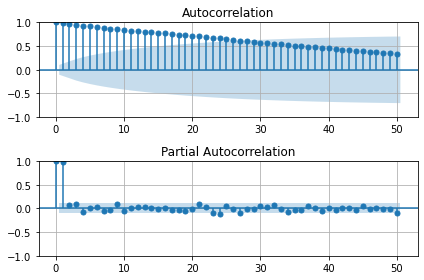

In [28]:
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data_train['Adj Close'].squeeze(), lags=50, ax=ax1)
plt.ylim([-1,1.0])
plt.grid()

ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_train['Adj Close'], lags=50, ax=ax2)
plt.ylim([-1.0,1.0])
plt.grid()

plt.tight_layout()

The PACF plot can help us pick p value i.e the number of autoregressive terms. PACF should ideally
taper off after this lag value. However, we will let AutoARIMA pick the p value for this.

Before we fit the AutoARIMA model, let us decompose the time series to understand the periodicity.

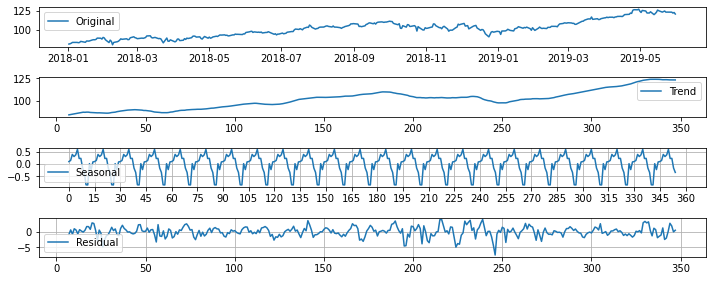

In [15]:
#We will try decomposition i.e. decompose the time series
#into trend, seasonal and residual. 

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(list(data_train['Adj Close']), period=15)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,4))
plt.subplot(411)
plt.plot(data_train['Adj Close'], label = 'Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label = 'Seasonal')
plt.xticks(np.arange(0.0,375.0,15.0))
plt.grid()
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')
plt.grid()
plt.tight_layout()

In [16]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(data_train['Adj Close'],start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5,
                        start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                        m=15, seasonal=True, error_action='warn', trace=True,
                        suppress_warnings=True, stepwise=True, random_state=20,
                        n_fits=50)
# m is a parameter denoting number of observations per seasonal cycle. 7,12,52 denote daily, monthly and weekly
# respectively. From the above seasonal plot, m=15.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[15]             : AIC=1543.916, Time=0.53 sec
 ARIMA(1,1,0)(1,1,0)[15]             : AIC=1451.763, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[15]             : AIC=inf, Time=3.68 sec
 ARIMA(1,1,0)(0,1,0)[15]             : AIC=1536.111, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[15]             : AIC=1411.216, Time=0.94 sec
 ARIMA(1,1,0)(3,1,0)[15]             : AIC=1388.610, Time=2.21 sec
 ARIMA(1,1,0)(4,1,0)[15]             : AIC=1375.410, Time=4.46 sec
 ARIMA(1,1,0)(5,1,0)[15]             : AIC=1373.996, Time=7.65 sec
 ARIMA(1,1,0)(5,1,1)[15]             : AIC=inf, Time=67.20 sec
 ARIMA(1,1,0)(4,1,1)[15]             : AIC=inf, Time=31.94 sec
 ARIMA(0,1,0)(5,1,0)[15]             : AIC=1383.197, Time=9.37 sec
 ARIMA(2,1,0)(5,1,0)[15]             : AIC=1366.392, Time=28.00 sec
 ARIMA(2,1,0)(4,1,0)[15]             : AIC=1368.249, Time=10.80 sec
 ARIMA(2,1,0)(5,1,1)[15]             : AIC=inf, Time=65.99 sec
 ARIMA(2,1,0)(4,1,1)[15]          

In [17]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  355
Model:             SARIMAX(2, 1, 0)x(5, 1, 0, 15)   Log Likelihood                -675.196
Date:                            Mon, 04 Oct 2021   AIC                           1366.392
Time:                                    12:20:07   BIC                           1397.000
Sample:                                         0   HQIC                          1378.590
                                            - 355                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2110      0.046     -4.605      0.000      -0.301      -0.121
ar.L2         -0.1689      0.050     -3.398      0.001      -0.266      -0.071
ar.S.L15      -0.8225      0.053    -15.374      0.000      -0.927      -0.718
ar.S.L30      -0.6919      0.072     -9.561      0.000      -0.834      -0.550
ar.S.L45      -0.5022      0.077     -6.503      0.000      -0.654      -0.351
ar.S.L60      -0.3148      0.075     -4.177      0.000      -0.463      -0.167
ar.S.L75      -0.1148      0.065     -1.758      0.079      -0.243       0.013
sigma2         3.0056      0.204     14.759      0.000       2.606       3.405
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 7.63
Prob(Q):                              0.84   Prob(JB):                         0.02
Heteroskedasticity (H):               1.48   Skew:                            -0.17
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
#Predicting the time series for the future.
periods = len(data_test)
prediction = pd.DataFrame(arima_model.predict(n_periods=periods),index=data_test.index)
prediction.columns = ['predicted_adj_close']
prediction

,predicted_adj_close
Date,
2019-06-03,121.435130
2019-06-04,121.279270
2019-06-05,122.608194
2019-06-06,122.766002
2019-06-07,123.777195
...,...
2019-12-23,152.336536
2019-12-24,151.970320
2019-12-26,151.327450


Plot the original and prediction.

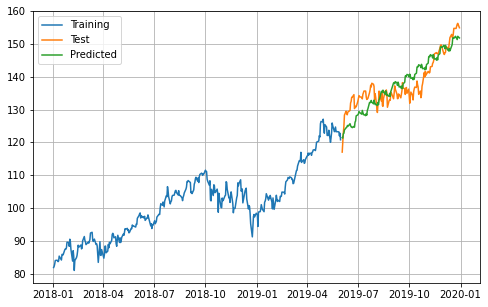

In [19]:
plt.figure(figsize=(8,5))
plt.plot(data_train['Adj Close'], label='Training')
plt.plot(data_test['Adj Close'], label='Test')
plt.plot(prediction['predicted_adj_close'], label='Predicted')
plt.legend(loc='best')
plt.grid()
plt.show()

In [20]:
from sklearn.metrics import r2_score
r2_score(data_test['Adj Close'], prediction['predicted_adj_close'])

0.6945567446652214

# Appendix

Visualizations and EDA of the time series data.

In [21]:
#Now we need to evaluate the Stationarity of the training set.
#We will plot the moving average and moving std to understand this.
def eval_stationarity(time_series, win=30, yzoom = []):
    rolling_mean = time_series.rolling(window = win).mean()
    rolling_std = time_series.rolling(window = win).std()
    #plot the original
    plt.figure(figsize = (12,4))
    if(yzoom): #zoom if necessary
        plt.ylim([yzoom[0],yzoom[1]])
    plt.plot(time_series, color = 'black', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'blue', label = 'Rolling Std')
    plt.title('Rolling Mean and Std with Window of %d'%(win))
    plt.legend(loc = 'best')
    plt.grid()
    plt.show(block = False)
    
     #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
        'p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

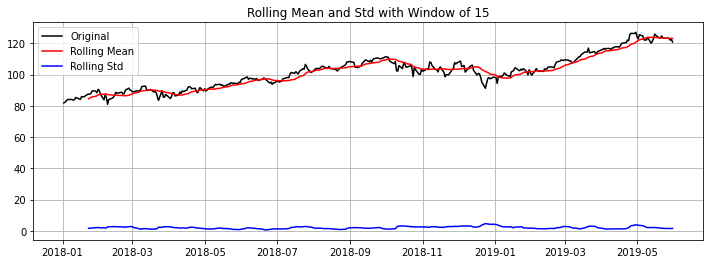

Results of Dickey-Fuller Test:
Test Statistic                  -0.986261
p-value                          0.758242
#Lags Used                       2.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64


In [26]:
eval_stationarity(data_train['Adj Close'],win = 15)